In [1]:
from utils.transforms import *

In [267]:
import imgaug.augmenters as iaa
from torchvision import transforms as T
import numpy as np
from imgaug.augmenters import Augmenter
import cv2

In [57]:
from random import uniform

In [ ]:
class Crop(Augmenter):
    def __init__(self, box_csv, extend_share=(0,1), name=None, deterministic=False, random_state=None):
        super(Crop, self).__init__(name=name, deterministic=deterministic, random_state=random_state)
        self.box_csv = 
        

    def _augment_images(self, images, random_state, parents, hooks):
        for i in range(nb_images):
            if samples[i] == 1:
                images[i] = np.fliplr(images[i])
        return images

    def get_parameters(self):
        return [self.p]

In [ ]:
def crop_img(img):
    return img[:50,:50,:]

def func_images(images, random_state, parents, hooks):
    images = [crop_img(images[i]) for i in range(len(images))]
    return images
    
def func_heatmaps(heatmaps, random_state, parents, hooks):
    return heatmaps
    
def func_keypoints(keypoints_on_images, random_state, parents, hooks):
    return keypoints_on_images

crop_augmenter = iaa.Lambda(
    func_images=func_images,
)

aug = iaa.Sequential([iaa.Fliplr(0.5), crop_augmenter(d=1), iaa.Sometimes(0.2, iaa.AverageBlur(k=(3,3)))]).augment_image

In [51]:
img = np.random.rand(100, 100, 3)

In [ ]:
img_ = aug(img)

In [45]:
img_.shape

(50, 50, 3)

In [1]:
import pandas as pd
from torch.utils.data import DataLoader
from utils import get_augmentation_list, TrainImageDataset, TestImageDataset, DummyDataset3
import os

In [20]:
data_csv = pd.read_csv("/home/kutsenko/projects/happywhale/data/train_.csv")
data_csv['image'] = data_csv['image'].apply(lambda x: x.replace('.jpg', '.png'))
dataset = TrainImageDataset(data_csv[1:5].reset_index(drop=True),
                            '/home/kutsenko/kaggle/segmented/seg_img',
                            transform=None)
# dataset = TestImageDataset('/home/kutsenko/kaggle/segmented/seg_img_test',
#                             transform=None)


In [21]:
from ffcv.fields import RGBImageField, BytesField, IntField, NDArrayField
from ffcv.writer import DatasetWriter


write_path = '/home/kutsenko/kaggle/ffcv/seg_train2.beton'


# writer = DatasetWriter(write_path, {
#     'image': RGBImageField(),
#     'img_name': BytesField()
# }, num_workers=10)
writer = DatasetWriter(write_path, {
    'image': RGBImageField(),
    'label': IntField()
}, num_workers=10)

writer.from_indexed_dataset(dataset)


100%|██████████| 4/4 [00:00<00:00, 39.81it/s]


In [2]:
from ffcv.loader import Loader, OrderOption
from ffcv.transforms import ToTensor, ToDevice, ToTorchImage
from ffcv.fields.decoders import IntDecoder, SimpleRGBImageDecoder, BytesDecoder
from PIL.Image import fromarray
from torch import nn
import torch
from random import uniform

In [354]:
import os

In [355]:
os.num_workers()

AttributeError: module 'os' has no attribute 'num_workers'

In [3]:
write_path = '/home/kutsenko/kaggle/ffcv/seg_train2.beton'

In [343]:
import numpy as np
from kornia.augmentation import *
from kornia.augmentation.container import AugmentationSequential
import cv2


class Augmenter(nn.Module):
    def __init__(self):
        super().__init__()
        self.aug_list = AugmentationSequential(
            RandomHorizontalFlip(p=0.5),
            AugmentationSequential(RandomGaussianBlur(kernel_size=(3, 3), sigma=(0.2, 1.5), p=0.5),
                                   RandomMotionBlur(kernel_size=(3, 3), angle=(-90,90), direction=0, p=0.5),
                                   random_apply=1),
            ColorJitter(brightness=(0.95, 1.2),
                        contrast=(0.8, 1.3),
                        saturation=(0.7, 1.3),
                        hue=0.01,
                        p=0.6),
            AugmentationSequential(RandomThinPlateSpline(scale=0.2, p=0.65),
                                   RandomRotation(degrees=(-15, 15), p=0.65),
                                   RandomPerspective(distortion_scale=0.2, p=0.65),
                                   random_apply=1),
            
            AugmentationSequential(RandomErasing(scale=(0.02, 0.07), ratio=(0.7, 1.3), value=0.0, p=0.3),
                                   RandomErasing(scale=(0.015, 0.07), ratio=(0.7, 1.3), value=0.0, p=0.2),
                                   RandomErasing(scale=(0.015, 0.07), ratio=(0.7, 1.3), value=0.0, p=0.2),
                                   )
            
            
        )
    
    def forward(self, x):
        return self.aug_list(x.type(torch.float32) / 255.)
    

In [344]:
image_pipeline = [SimpleRGBImageDecoder(), ToTensor(), ToTorchImage(), Augmenter()]
# image_pipeline = [SimpleRGBImageDecoder(), ToTensor(), ToTorchImage()]
label_pipeline = [IntDecoder()]

pipelines = {
    'image': image_pipeline,
    'label': label_pipeline
}

loader = Loader(write_path, batch_size=1, num_workers=1,
                order=OrderOption.SEQUENTIAL, pipelines=pipelines)



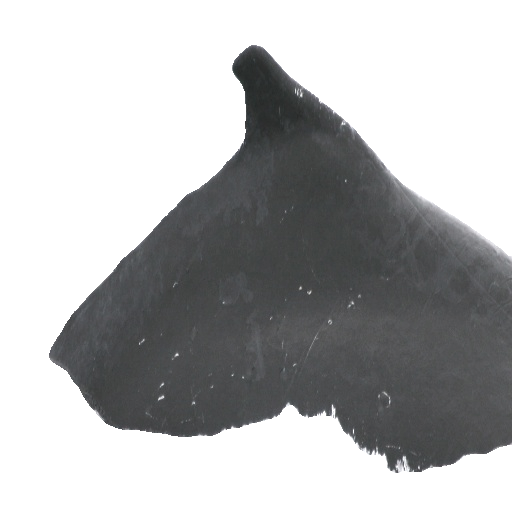

In [353]:
for i, x in loader:
    img = np.moveaxis((i[0] * 255.).type(torch.uint8).numpy(), 0, -1)
    # img = i[0]
    break

fromarray(img)

In [115]:
path = '/home/kutsenko/kaggle/segmented/seg_img/'
imgs_n = os.listdir(path)
img_p = path + imgs_n[0]

In [271]:
img = cv2.imread(img_p)

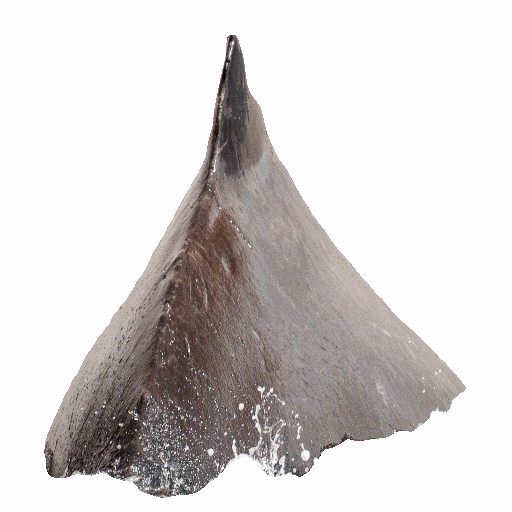

In [272]:
fromarray(img)

In [273]:
type(img)

numpy.ndarray

In [276]:
img_tensor = torch.from_numpy(img).type(torch.float32)

In [286]:
aug = augmentation.RandomErasing(p=1, scale=(0.05, 0.07), ratio=(0.5, 1.5))

In [287]:
y = aug(img_tensor)

In [288]:
y = y.type(torch.uint8).numpy()[0]

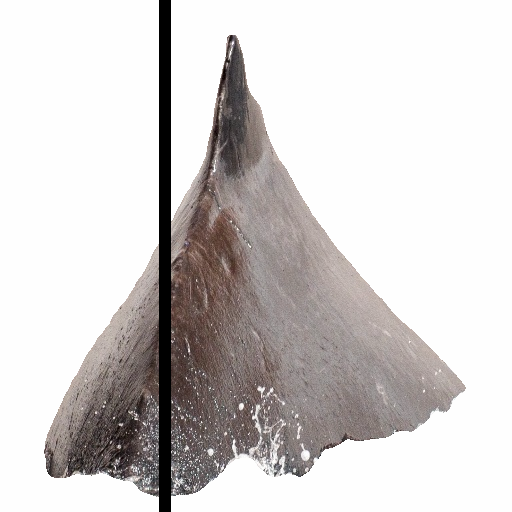

In [290]:
fromarray(y)